In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from matplotlib import pyplot as plt
import torch

from grconvnet.dataloading.datasets import YCBSimulationData
from grconvnet.preprocessing import Preprocessor, CenterCropResized, Masker
from grconvnet.postprocessing import Postprocessor, SkGaussian, Scaler, GraspLocalizer, DeCenterCropResized, Img2WorldConverter, Img2WorldCoordConverter, GraspHeightAdjuster
from grconvnet.models import GenerativeResnet
from grconvnet.utils import visualization as vis

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dataset = YCBSimulationData(
    Path("/home/moritz/Documents/ycb_sim_data_1"),
    transform=Preprocessor(
        reformatter=CenterCropResized((224, 224)),
        masker=Masker(negative_value=[255, 255, 255], positive_value=[0, 0, 0]),
    ),
)

device = "cuda"
model = GenerativeResnet.from_jit(device=device)

postprocessor = Postprocessor(
    q_blurrer=SkGaussian(2),
    angle_blurrer=SkGaussian(2),
    width_blurrer=SkGaussian(1),
    width_scaler=Scaler(150),
    grasp_localizer=GraspLocalizer(min_distance=20, threshold=0.2, n_grasps=5),
)

img2world_converter = Img2WorldConverter(
    coord_converter=Img2WorldCoordConverter(),
    decropper=DeCenterCropResized(),    
    height_adjuster=GraspHeightAdjuster(
        min_height=0.01,
        target_grasp_depth=0.04,
    ),
)


In [3]:
sample = dataset[-1]
sample = sample.to(device)

with torch.no_grad():
    predictions = model(sample.unsqueeze(0))

grasps_img = postprocessor(predictions)

grasps_world = [
    img2world_converter(
        g_img,
        dataset.transform.intermediate_results["initial_sample"].depth,
        dataset.transform.intermediate_results["initial_sample"].cam_intrinsics,
        dataset.transform.intermediate_results["initial_sample"].cam_rot,
        dataset.transform.intermediate_results["initial_sample"].cam_pos,
    )
    for g_img in grasps_img
]


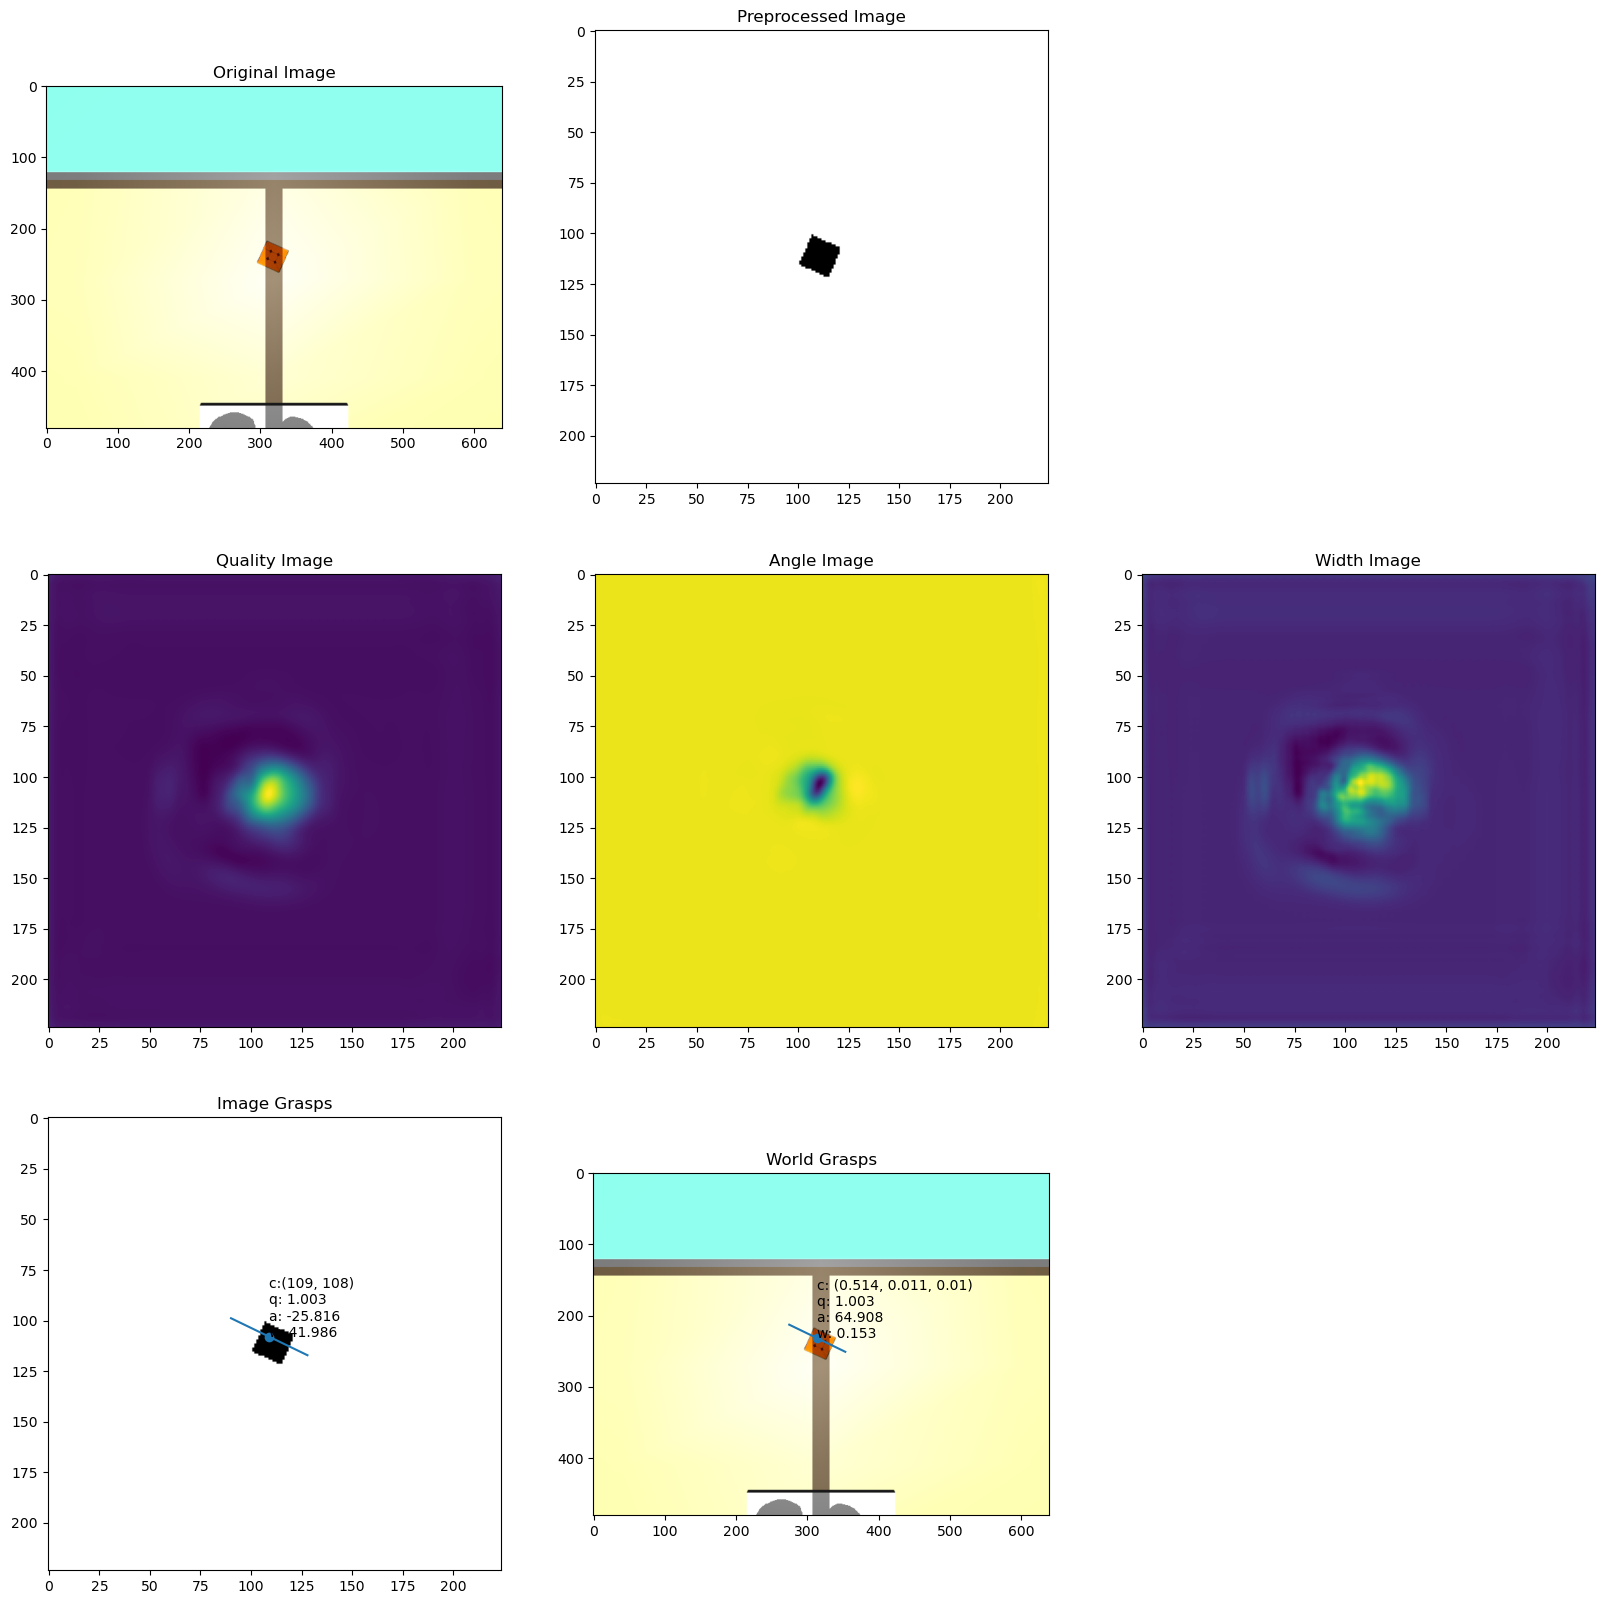

In [5]:
fig = vis.overview_fig(
    fig=plt.figure(figsize=(20, 20)),
    original_rgb=vis.make_tensor_displayable(
        dataset.transform.intermediate_results["initial_sample"].rgb, True, True
    ),
    preprocessed_rgb=vis.make_tensor_displayable(
        dataset.transform.intermediate_results["rgb_masked"], True, True
    ),
    q_img=vis.make_tensor_displayable(
        postprocessor.intermediate_results["q_img"], False, False
    ),
    angle_img=vis.make_tensor_displayable(
        postprocessor.intermediate_results["angle_img"], False, False
    ),
    width_img=vis.make_tensor_displayable(
        postprocessor.intermediate_results["width_img"], False, False
    ),
    image_grasps=grasps_img,
    world_grasps=grasps_world,
    cam_intrinsics=dataset.transform.intermediate_results[
        "initial_sample"
    ].cam_intrinsics,
    cam_rot=dataset.transform.intermediate_results["initial_sample"].cam_rot,
    cam_pos=dataset.transform.intermediate_results["initial_sample"].cam_pos,
)

plt.show()
